<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Fastai%20NLP%20course/9_Translation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Video 12](https://youtu.be/IfsjMg4fLWQ)

**Summary of my results**
 
    
  |model            | train_loss | valid_loss | seq2seq_acc | bleu|
    |-------------------|----------|----------|----------|----------|
    |seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899|
    |+ teacher forcing | 3.154585 |4.022432 | 0.407792 | 0.310715|
    |+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232|
    |transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880|

**Material:**

https://mlexplained.com/2017/12/29/attention-is-all-you-need-explained/

https://mlexplained.com/2019/06/30/paper-dissected-xlnet-generalized-autoregressive-pretraining-for-language-understanding-explained/


# Translation with an RNN

This notebook is modified from[ this one](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb) created by Sylvain Gugger.

Today we will be tackling the task of translation. We will be translating from French to English, and to keep our task a manageable size, we will limit ourselves to translating questions.

This task is an example of sequence to sequence (seq2seq). Seq2seq can be more challenging than classification, since the output is of variable length (and typically different from the length of the input.

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html . It was created by Chris Callison-Burch, who crawled millions of web pages and then used a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other.

Translation is much tougher in straight PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

## Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)

A sequence-to-sequence model is a model that takes a sequence of items (words, letters, features of an images…etc) and outputs another sequence of items. A trained model would work like this:



In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="170" src="https://jalammar.github.io/images/seq2seq_1.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In neural machine translation, a sequence is a series of words, processed one after another. The output is, likewise, a series of words:

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="170" src="https://jalammar.github.io/images/seq2seq_2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### Looking under the hood

Under the hood, the model is composed of an encoder and a decoder.

The encoder processes each item in the input sequence, it compiles the information it captures into a vector (called the context). After processing the entire input sequence, the encoder send the context over to the decoder, which begins producing the output sequence item by item.

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="170" src="https://jalammar.github.io/images/seq2seq_3.mp4" frameborder="0" allow="accelerometer; autoplay loop; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The same applies in the case of machine translation.

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="170" src="https://jalammar.github.io/images/seq2seq_4.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The **context** is a vector (an array of numbers, basically) in the case of machine translation. The **encoder and decoder** tend to both be recurrent neural networks (Be sure to check out [Luis Serrano’s A friendly introduction to Recurrent Neural Networks for an intro to RNNs](https://www.youtube.com/watch?v=UNmqTiOnRfg)).

![alt text](https://jalammar.github.io/images/context.png)

    The context is a vector of floats. Later in this post we will visualize vectors in color by assigning brighter colors to the cells with higher values.
    
You can set **the size of the context vector** when you set up your model. It is **basically the number of hidden units** in the encoder RNN. These visualizations show a vector of size 4, but in real world applications the context vector would be of a size like 256, 512, or 1024.

By design, a RNN takes two inputs at each time step: an input (in the case of the encoder, one word from the input sentence), and a hidden state. The word, however, needs to be represented by a vector. To transform a word into a vector, we turn to the class of methods called “[word embedding](https://machinelearningmastery.com/what-are-word-embeddings/)” algorithms. These turn words into vector spaces that capture a lot of the meaning/semantic information of the words (e.g. [king - man + woman = queen](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html)).

![alt text](https://jalammar.github.io/images/embedding.png)


```
We need to turn the input words into vectors before processing them. That transformation is done using a word embedding algorithm. We can use pre-trained embeddings or train our own embedding on our dataset. Embedding vectors of size 200 or 300 are typical, we're showing a vector of size four for simplicity.
```

Now that we’ve introduced our main vectors/tensors, let’s recap the mechanics of an RNN and establish a visual language to describe these models:




In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="350" src="https://jalammar.github.io/images/RNN_1.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The next RNN step takes the second input vector and hidden state #1 to create the output of that time step. Later in the post, we’ll use an animation like this to describe the vectors inside a neural machine translation model.



In the following visualization, each pulse for the encoder or decoder is that RNN processing its inputs and generating an output for that time step. Since the encoder and decoder are both RNNs, each time step one of the RNNs does some processing, it updates its hidden state based on its inputs and previous inputs it has seen.

Let’s look at the hidden states for the encoder. Notice how the last hidden state is actually the context we pass along to the decoder.

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="570" height="250" src="https://jalammar.github.io/images/seq2seq_5.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The decoder also maintains a hidden states that it passes from one time step to the next. We just didn’t visualize it in this graphic because we’re concerned with the major parts of the model for now.

Let’s now look at another way to visualize a sequence-to-sequence model. This animation will make it easier to understand the static graphics that describe these models. This is called an “unrolled” view where instead of showing the one decoder, we show a copy of it for each time step. This way we can look at the inputs and outputs of each time step.

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="250" src="https://jalammar.github.io/images/seq2seq_6.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [0]:
from fastai.text import *

##Download and preprocess our data

We will start by reducing the original dataset to questions. You only need to execute this once, uncomment to run. The dataset can be downloaded [here](https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz).

In [0]:
path = Config().data_path()

In [0]:
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

--2019-08-24 13:53:24--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.132.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.132.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/root/.fastai/data/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  60.7MB/s    in 45s     

2019-08-24 13:54:09 (55.5 MB/s) - ‘/root/.fastai/data/giga-fren.tgz’ saved [2598183296/2598183296]



In [0]:
! tar xf {path}/giga-fren.tgz -C {path}

In [0]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

In [0]:
#with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')

In [0]:
#with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')

We will use regex to pick out questions by finding the strings in the English dataset that start with "Wh" and end with a question mark. You only need to run these lines once:

In [0]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [0]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [0]:
qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

## Load our data into a DataBunch

Our questions look like this now:

In [0]:
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


To make it simple, we lowercase everything.

In [0]:
df['en'] = df['en'].apply(lambda x : x.lower())
df['fr'] = df['fr'].apply(lambda x : x.lower())


The first thing is that we will need to collate inputs and targets in a batch because they have different lengths so we need to add padding to make the sequence length the same. By adding zeros to fill out the length. 

Later on we are going to throw away sentences that are too long and again to make this simpler and have kind of an easy batch that we can put on GPU

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

- doc(Dataset): Dataset class is an abtract class that represent a dataset. Abtract class is kind of defining these things that we want a dataset to have. In this case, we are saying any data specific type of dataset you create, it's going to have a length (`__len__`) as well as `__getitem__` which is basically a way to index into it. This is what gives you the ability to index into something and we'll subclass it which means we are making a class we are inherting from it

- doc(DataLoader): the DataLoader is going to give us a way to iterate over a dataset. So we want something that we can call and it will return a batch of the data. In detail, it has batch size , shuffle your batches to change the order. It is usefull with neural network since we're looking at a batch of data at a time, you need a way to get out a batch of data 


```
class DataLoader[test]
        DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn='default_collate', pin_memory=True, drop_last=False, timeout=0, worker_init_fn=None)
```


- doc(DataBunch) : The DataBunch is built on DataLoader. This gives you 2 or 3 DataLoader,  including training dataloader, validation dataloader and optionally test dataloader. This is kind of a way to store your training set, validation set and test set all together in one place. You'll be able to return batches of any of those from this DataBunch. This is usefull object for kind of keeing pieces that you need together

Then we create a special DataBunch that uses this collate function. This seq2seqDataBunch  create a type of text databunch that suitable for training a RNN. We do that by adding @classmethod that how to create a seq2seqDataBunch

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

**SortishSampler??**:  this is from Fastai lib. Go through the text data by order of length with a bit of randomness



```
class SortishSampler(Sampler):
    "Go through the text data by order of length with a bit of randomness."

    def __init__(self, data_source:NPArrayList, key:KeyFunc, bs:int):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = np.random.permutation(len(self.data_source))
        sz = self.bs*50
        ck_idx = [idxs[i:i+sz] for i in range(0, len(idxs), sz)]
        sort_idx = np.concatenate([sorted(s, key=self.key, reverse=True) for s in ck_idx])
        sz = self.bs
        ck_idx = [sort_idx[i:i+sz] for i in range(0, len(sort_idx), sz)]
        max_ck = np.argmax([self.key(ck[0]) for ck in ck_idx])  # find the chunk with the largest key,
        ck_idx[0],ck_idx[max_ck] = ck_idx[max_ck],ck_idx[0]     # then make sure it goes first.
        sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
        sort_idx = np.concatenate((ck_idx[0], sort_idx))
        return iter(sort_idx)
File:           /usr/local/lib/python3.6/dist-packages/fastai/text/data.py
Type:           type
```

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/padding.png?raw=true)

For example, you have 3 sentences with different length. With shorter sentence, you have fill padding to make equal length. The issue is if one the these sentences was much longer,  it would cost extra computation of having to make all these things longer. So there's the benefit to sorting by sentence length through your batches. However if you sort perfectly, you will get the downside that for every epoch is you're training your batches will be identical and this can cause your model to not generalize as well because it might be kind of learning these in synthesis of how you have your data sorted if it's always the same . So the benefit of sortish is that it's giving you some randomness and your batches will be different each time but they'll still close enough that you're not losing time on performance from having to fill out really short sentences with ton of padding 

And a subclass of TextList that will use this DataBunch class in the call .databunch and will use TextList to label (since our targets are other texts).

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!. 

Before we process our French and English questions, put those into dataframe (df). Now we create seq2seq list for a TextList from that 

In [0]:
src = Seq2SeqTextList.from_df(df,path=path,cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en',label_cls=TextList)

Now we want to look at 90th percentile. We use numpy method, basically we want to see how long are these items and we get 28 is the 90th percentile for x and 24 for y

- x is French
- y is English

In [0]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items],90)

28.0

In [0]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.x.items],90)

24.0

We remove the items where one of the target is more than 30 tokens long. Since not many items fall in that it's less than 10% and this will kind of make it simpler for what we are working with. And we're not throwing much data by doing this. 

It's interesting to note that French seem to be longer than English on the whole (28 vs 24)

In [0]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) >30)

In [0]:
len(src.train) + len(src.valid)

48350

In [0]:
data = src.databunch()

In [0]:
data.save()

In [0]:
data

Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: /root/.fastai/data/giga-fren;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?
y: TextList
x

In [0]:
path

PosixPath('/root/.fastai/data/giga-fren')

In [0]:
data = load_data(path)

In [0]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


## Create our Model



### Pretrained embeddings

You will need to download the word embeddings (crawl vectors) from the fastText docs. FastText has [pre-trained word vectors](https://fasttext.cc/docs/en/crawl-vectors.html) for 157 languages, trained on Common Crawl and Wikipedia. These models were trained using CBOW.

If you need a refresher on word embeddings, you can check out my gentle intro in this [word embedding workshop](https://www.youtube.com/watch?v=25nC0n9ERq4&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=10&t=0s) with accompanying [github repo](https://github.com/fastai/word-embeddings-workshop).

More reading on CBOW (Continuous Bag of Words vs. Skip-grams):

- [fastText tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html#advanced-readers-skipgram-versus-cbow)
- [StackOverflow](https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words)


To install fastText:


```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```



In [0]:
!pip install fastText

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for fastText: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2379300 sha256=d953e2d6c462bcca60b75351dafc883585a0680bb45d92c042cf8b96b919dec6
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fastText


In [0]:
import fasttext as ft

In [0]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2019-08-24 05:42:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/root/.fastai/data/giga-fren/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  36.7MB/s    in 1m 58s  

2019-08-24 05:44:37 (36.4 MB/s) - ‘/root/.fastai/data/giga-fren/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2019-08-24 05:44:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting 

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/root/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/root/.fastai/data/giga-fren/cc.fr.300.bin.gz'),
 PosixPath('/root/.fastai/data/giga-fren/cc.en.300.bin.gz'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/root/.fastai/data/giga-fren/data_save.pkl')]

In [0]:
!gunzip {path}/cc.en.300.bin.gz
!gunzip {path}/cc.fr.300.bin.gz

In [0]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

We create an embedding module with the pretrained vectors and random data for the missing parts.

In [0]:
def create_emb(vecs,itos,em_sz = 300,mult=1.):
    emb = nn.Embedding(len(itos),em_sz,padding_idx=1)
    wgts =emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try : wgts[i]:tensor(vec_dic[w])
        except : miss.append(w)
    return emb
    

In [0]:
emb_enc=create_emb(fr_vecs,data.x.vocab.itos)
emb_dec=create_emb(en_vecs,data.y.vocab.itos)

In [0]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [0]:
os.makedirs('/root/.fastai/models/',exist_ok=True)
model_path = '/root/.fastai/models'

In [0]:
torch.save(emb_enc, f'{model_path}/fr_emb.pth')
torch.save(emb_dec, f'{model_path}/en_emb.pth')

In [0]:
#shutil.copy(f'{model_path}/fr_emb.pth','/content')
#shutil.copy(f'{model_path}/en_emb.pth','/content')

'/content/en_emb.pth'

In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

TypeError: ignored

### Our Model

**Review Question:** What are the two types of numbers in deep learning?

**Encoders & Decoders**

The model in itself consists in an encoder and a decoder

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/seq2seq.png?raw=True)

The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state. **A hidden state** is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training).

We will use a GRU for our encoder and a separate GRU for our decoder. Other options are to use LSTMs or QRNNs (see here). GRUs, LSTMs, and QRNNs all solve the problem of how RNNs can lack long-term memory.

Links:

- Illustrated Guide to LSTM’s and GRU’s: A step by step explanation
- fast.ai implementation of seq2seq with QRNNs

In [0]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)


```
def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
```

The forward step is going to put the batch size and input into an encoder and get out a hidden state. Our decode input need to be initialized to right size and to start with beginning of string. 

And then we'll go through an for loop where in each step that we are putting our decode input (**dec_inp** ) and our hidden state (**h**) we got from an encoder.  We put all these into a decoder _ **self.decoder(dec_inp,h)** , then we get out the hidden state and an output as well.

**dec_inp = out.max(1)[1]** : take the max of that to get decoder input 

**res.append(outp)**: we want to hold on to what our output was from the decoder. 

**if (dec_inp==self.pad_idx).all(): break** : Then if we have a padding token we'll break out of this 

**return torch.stack(res,dim=1)** : at the end, we'll return our results 

=> in summary, you are putting your input into an encoder and then in a for loop you re getting something out of the decoder each time 



```
 def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
```

it is taking the embedding that we had prepared for the encoder and we put the input into embedding - **`self.emb_enc(inp)`** - . That basically is taking the French words and picking out what French are the vectors word embedding for those . Then we apply the dropout - **`self.emb_enc_drop(self.emb_enc(inp))`** which do regularization 

**`_,h = self.gru_enc(emb,h)`** : put that into our first GRU since this uses two different GRUs. This one is learning for the encoder . It including embedding and hidden state of what came before 

**`h = self.out_enc(h)`** : hidden_state will be put into a Linear layer - self.out_enc -> return a final hidden state 





```
def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
```
we get the decoder input (dec_inp) . 

**`emb = self.emb_dec(dec_inp).unsqueeze(1)`** :Then we put into embedding and add a dimension (unsqueeze(1)) 

**`outp, h = self.gru_dec(emb, h)`** : we put our emb and h through GRU decoder -> this is our second GRU 

**`outp = self.out(self.out_drop(outp[:,0]))`**: Then apply some dropout then apply self.out which is a Linear layer ,

**`return h, outp`** : finally we get output from there 

In [0]:
xb,yb = next(iter(data.valid_dl))

In [0]:
xb.shape

torch.Size([64, 30])

In [0]:
rnn = Seq2SeqRNN(emb_enc,emb_dec,256,30)

- emb_enc=English embedding
- emb_dec = French embedding 
- 256 : is a number of hidden layers
- 30 : is a sequence length 

In [0]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [0]:
len(xb[0])

30

In [0]:
h = rnn.encoder(64,xb.cpu())

In [0]:
h.size()

torch.Size([2, 64, 300])

hidden state size is 2x64x300 :

- 2 : number of hidden layers inside GRU
- 64 : is batch size
- 300 : is the dimension of the embedding


The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

### Train our model

In [0]:
learn = Learner(data,rnn,loss_func=seq2seq_loss)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


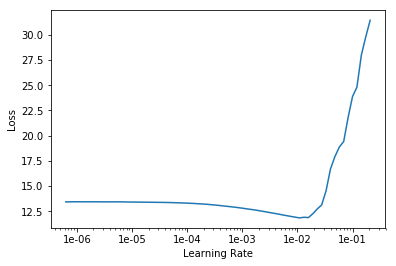

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,5.198815,5.412505,01:17
1,4.929246,4.815796,01:08
2,4.721554,4.963487,01:07
3,4.504862,5.290407,01:09


let's free up some RAM

In [0]:
del fr_vecs
del en_vecs

As loss is not very interpretable, it's nice to see they are both decreasing but in terms of human interpretability , we don't really know how good is our model based on these losses , we dont' have the meaning for that

Let's also look at the accuracy. Again, we will add padding so that the output and target are of the same length.

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

#### BLEU

[Video 12 - 27:29](https://youtu.be/IfsjMg4fLWQ?t=1649)

The problem, although accuracy is technical definition but measuring how good a translation model is a little bit trickier.

One of the metric is deal with this called **BLEU**


In translation, the metric usually used is BLEU.

A great post by Rachael Tatman: [Evaluating Text Output in NLP: BLEU at your own risk](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)



In [0]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)


**`bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)`** : we are taking the average of the 4 precisions and these corresponding to unigram, bi-gram,tri-gram, 4-gram. We capture  averaging ** 0.25 and then mutiplying by brevity penalty (len_penalty).

To remind why we need brevity penalty : the answer is in case the length is too short , it's left out information and we want to penalize that . That's how BLEU deals with that.

#### Training with metrics

In [0]:
learn = Learner(data,rnn,loss_func=seq2seq_loss,metrics=[seq2seq_acc,CorpusBLEU(len(data.y.vocab.itos))])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


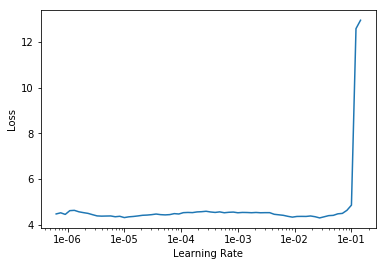

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4,1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.482030,5.682566,0.245021,0.219095,01:24
1,4.530885,5.019033,0.312583,0.253177,01:27
2,4.300954,5.511343,0.253818,0.226397,01:26
3,4.150765,4.866162,0.321122,0.250603,01:26


In [0]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.145194,5.134167,0.294418,0.233603,01:25
1,3.939709,4.613554,0.347170,0.274131,01:27
2,3.781650,4.792542,0.329084,0.261027,01:28
3,3.806191,4.636693,0.345565,0.270017,01:28


So how good is our model? Let's see a few predictions.

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[700], targets[700], outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who has the the the the the and and and and and)

In [0]:
inputs[702], targets[702], outputs[702]

(Text xxbos qui a le pouvoir de modifier la loi sur les poids et mesures et la loi sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection act or the weights and measures act ?,
 Text xxbos who has the the the the the the and and and the the the)

In [0]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?,
 Text xxbos what two trends negatively affected the province ’s salmon fishery ?,
 Text xxbos what are the two two the the the the the the two two two ?)

In [0]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos où les aires marines nationales de conservation du canada seront - elles situées ?,
 Text xxbos where will national marine conservation areas of canada be located ?,
 Text xxbos where is the canada of the the the ? ?)

It's usually beginning well, but falls into repeated words at the end of the question.

To address the issue of starting but then end up with repeated words. These issues are :

- RNN doesn't have a chance to get back on track because the input is the previous words. " where are the the the the the the ?" its own incorrect output becomes input for next stage which is the problem 

The technique to deal with it is **Teaching forcing**


### + Teaching forcing : technique to address the issue of previous model [45:41](https://youtu.be/IfsjMg4fLWQ?t=2711)

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.



In [0]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

The one thing about teaching forcing it's slightly incentivize the model to take more risk because it gets something wrong, it's still gonna be fine the next time since you're going to show it  the answer before it's next prediction. So basically we gradually reduce the  amount of teaching forcing. But at the beginning, we want to do a lot because the model is not very good like we're just starting to train it. Of course, it's gonna get stuff wrong and we don't want that  to just screw it up so that it can't learn.

**`self.learn.model.pr_force = 1 - epoch/self.end_epoch`** : pr-force is probability of forcing , that will start high, start at 1 and gradually decrease until the end of the epoch . We want the probability of forcing to be zero. In the real world, we don't have the answer everytime 

We will add the following code to our forward method:

   
```
 if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
```


Additionally, forward will take an additional argument of target.

In [0]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
                #---------add teacher forcing----------
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
                #-------------------------------------
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [0]:
emb_enc = torch.load(f'{model_path}/fr_emb.pth')
emb_dec = torch.load(f'{model_path}/en_emb.pth')

In [0]:
rnn_tf = Seq2SeqRNN_tf(emb_enc,emb_dec,256,30)

In [0]:
learn = Learner(data,rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))], 
               callback_fns = partial(TeacherForcing, end_epoch=3))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


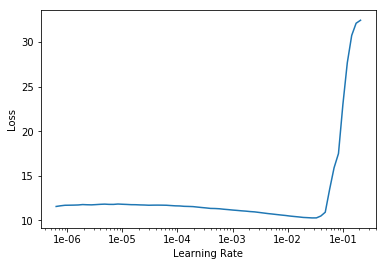

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.618804,8.096622,0.355594,0.299144,01:53
1,3.049555,5.257868,0.366460,0.328175,01:38
2,3.589221,5.363857,0.287679,0.269377,01:29
3,4.515140,5.295720,0.283943,0.211130,01:22
4,4.176762,5.049106,0.306556,0.248506,01:25
5,4.075339,5.044560,0.307807,0.242560,01:25


In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[700],targets[700],outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who has the the and the and and and and and)

In [0]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?,
 Text xxbos what two trends negatively affected the province ’s salmon fishery ?,
 Text xxbos what two the two two the the the the)

In [0]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos où les aires marines nationales de conservation du canada seront - elles situées ?,
 Text xxbos where will national marine conservation areas of canada be located ?,
 Text xxbos where will the the of the the be ? ?)

We can the see improvement of prediction

### + Attention [50:30](https://youtu.be/IfsjMg4fLWQ?t=3038)

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A nice illustration of attention comes from this [blog post](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar (visualization originally from [Tensor2Tensor notebook](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)):

From video : instead of only keeping the final hidden state from the encoder, now we want to keep the output at every state of the encoder. We also want to know which to focus on.

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/alammar-attention.png)

We have " The animal didn't cross the street because it was too tired". When you are working with "it" , it's really important to know "it" related to "animal", we wouldn't want to think it is the "street". As human, when read the sentence, we know what "it" refer to "animal". So the idea is in your output , you want to know what to focus on from the input . And so we are going to use **weights** or rather we're going to learn weights to learn that information of what we should be focusing on . So basically, we're going to end up taking a average of the output from the encoder at each step to know what were the key steps of the encoder for the particular word I'm on in the output. This will be different for each word of the output what you want to focus on from the input.


A second things that might help is to use **a bidirectional model for the encoder**. We set the bidrectional parameter to True for our GRU encoder, and double the number of inputs to the linear output layer of the encoder. Basically, we are doing one version of going forward and one version of going backward to get double information. That's shown up below

Also, we now need to set our hidden state:



```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```



#### Let’s Pay Attention Now

The context vector turned out to be a bottleneck for these types of models. It made it challenging for the models to deal with long sentences. A solution was proposed in [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473) and [Luong et al., 2015](https://arxiv.org/abs/1508.04025). These papers introduced and refined a technique called “Attention”, which highly improved the quality of machine translation systems. **Attention allows the model to focus on the relevant parts of the input sequence as needed.**

![alt text](https://jalammar.github.io/images/attention.png)


```
At time step 7, the attention mechanism enables the decoder to focus on the word "étudiant" ("student" in french) before it generates the English translation. This ability to amplify the signal from the relevant part of the input sequence makes attention models produce better results than models without attention.
```

Let’s continue looking at attention models at this high level of abstraction. An attention model differs from a classic sequence-to-sequence model in two main ways:

**First, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder:**





In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="250" src="https://jalammar.github.io/images/seq2seq_7.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

**Second, an attention decoder does an extra step before producing its output. In order to focus on the parts of the input that are relevant to this decoding time step, the decoder does the following:**

1. Look at the set of encoder hidden states it received – each encoder hidden states is most associated with a certain word in the input sentence
2. Give each hidden states a score (let’s ignore how the scoring is done for now)
3. Multiply each hidden states by its softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="570" height="310" src="https://jalammar.github.io/images/attention_process.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

This scoring exercise is done at each time step on the decoder side.

Let us now bring the whole thing together in the following visualization and look at how the attention process works:

1. The attention decoder RNN takes in the embedding of the `<END>` token, and an initial decoder hidden state.
2. The RNN processes its inputs, producing an output and a new hidden state vector (h4). The output is discarded.
3. **Attention Step**: We use the encoder hidden states and the h4 vector to calculate a context vector (C4) for this time step.
4. We concatenate h4 and C4 into one vector.
5. We pass this vector through a feedforward neural network (one trained jointly with the model).
6.The output of the feedforward neural networks indicates the output word of this time step.
7. Repeat for the next time steps

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="630" height="350" src="https://jalammar.github.io/images/attention_tensor_dance.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

This is another way to look at which part of the input sentence we’re paying attention to at each decoding step:

In [0]:
#@title 
from IPython.display import HTML

HTML('<iframe width="630" height="280" src="https://jalammar.github.io/images/seq2seq_9.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Note that the model isn’t just mindless aligning the first word at the output with the first word from the input. It actually learned from the training phase how to align words in that language pair (French and English in our example). An example for how precise this mechanism can be comes from the attention papers listed above:

![alt text](https://jalammar.github.io/images/attention_sentence.png)

#### Self-Attention at a High Level

Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should be familiar with. I had personally never came across the concept until reading the Attention is All You Need paper. Let us distill how it works.

Say the following sentence is an input sentence we want to translate:

”The animal didn't cross the street because it was too tired”

What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.

When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.

As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.

If you’re familiar with RNNs, think of how maintaining a hidden state allows an RNN to incorporate its representation of previous words/vectors it has processed with the current one it’s processing. Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing.

![alt text](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)



#### Self-Attention in Detail
Let’s first look at how to calculate self-attention using vectors, then proceed to look at how it’s actually implemented – using matrices.

The **first step** in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So **for each word, we create a Query vector, a Key vector, and a Value vector**. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.

Notice that these new vectors are smaller in dimension than the embedding vector. Their dimensionality is 64, while the embedding and encoder input/output vectors have dimensionality of 512. They don’t HAVE to be smaller, this is an architecture choice to make the computation of multiheaded attention (mostly) constant.

![alt text](http://jalammar.github.io/images/t/transformer_self_attention_vectors.png)




Multiplying $X_1$ by the $W^Q$ weight matrix produces $q_1$, the "query" vector associated with that word. We end up creating a "query", a "key", and a "value" projection of each word in the input sentence.

**What are the “query”, “key”, and “value” vectors? **

They’re abstractions that are useful for calculating and thinking about attention. Once you proceed with reading how attention is calculated below, you’ll know pretty much all you need to know about the role each of these vectors plays.

The **second step** in calculating self-attention is to calculate a score. Say we’re calculating the self-attention for the first word in this example, “Thinking”. We need to score each word of the input sentence against this word. The score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position.

The score is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring. So if we’re processing the self-attention for the word in position #1, the first score would be the dot product of $q_1$ and $k_1$. The second score would be the dot product of $q_1$ and $k_2$.

![alt text](http://jalammar.github.io/images/t/transformer_self_attention_score.png)

The third and forth steps are to divide the scores by 8 (the square root of the dimension of the key vectors used in the paper – 64. This leads to having more stable gradients. There could be other possible values here, but this is the default), then pass the result through a softmax operation. Softmax normalizes the scores so they’re all positive and add up to 1.

![](http://jalammar.github.io/images/t/self-attention_softmax.png)

    This softmax score determines how much how much each word will be expressed at this position. Clearly the word at this position will have the highest softmax score, but sometimes it’s useful to attend to another word that is relevant to the current word.



The **fifth step** is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

The **sixth step** is to sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

![](http://jalammar.github.io/images/t/self-attention-output.png)

That concludes the self-attention calculation. The resulting vector is one we can send along to the feed-forward neural network. In the actual implementation, however, this calculation is done in matrix form for faster processing. So let’s look at that now that we’ve seen the intuition of the calculation on the word level.




##### Matrix Calculation of Self-Attention

The first step is to calculate the Query, Key, and Value matrices. We do that by packing our embeddings into a matrix X, and multiplying it by the weight matrices we’ve trained ($W^Q$, $W^K$, $W^V$).

![alt text](http://jalammar.github.io/images/t/self-attention-matrix-calculation.png)

    Every row in the X matrix corresponds to a word in the input sentence. We again see the difference in size of the embedding vector (512, or 4 boxes in the figure), and the q/k/v vectors (64, or 3 boxes in the figure)
    
**Finally**, since we’re dealing with matrices, we can condense steps two through six in one formula to calculate the outputs of the self-attention layer.

![alt text](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

##### More explaination from Jeremy to what is Q, K and V? [Video 17](https://youtu.be/AFkGPmU16QA?t=1024)

- Q is going to learnt for the word I am currently translating. I am looking at word 1, Q is going to be for word 1. Then I look at all the other words in the sentence and say how much attention I give to each one when translating word 1.

- K is something that I learned for how can caculate for all the other words in the sentence, all of them including word 1

-> Q and K are going to get combined together to overall give a sense how relevant is the word represented by K to translating the word represented by Q. When they are combined together, this is forming a scalar.

- V is applied to same word that K is applied to. So you figured out how much attention you want to give to the thing for K given that we are looking up with the thing for Q. Then what we return is V. 

The intuition here that if we did not do K and Q , V is just weight matrix being fed into feed-forward neural net each time. But we don't just want the weight matrix for the current word. We want to have a mix of weight matrices based on how much attention we want to give them.

In the end, V is the weight matrix in neural network , Q and K tell how much to mix up all the different weight matrices in the different words 

![alt text](https://i2.wp.com/mlexplained.com/wp-content/uploads/2017/12/scaled_dot_product_attention.png?w=840)

![alt text](https://s0.wp.com/latex.php?latex=%5Ctextrm%7BAttention%7D%28Q%2C+K%2C+V%29+%3D+%5Ctextrm%7Bsoftmax%7D%28%5Cfrac%7BQK%5ET%7D%7B%5Csqrt%7Bd_k%7D%7D%29V+&bg=ffffff&fg=000&s=0)

#### Implement attention ( added only to decoder)

In [0]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        # we have two times of hidden state since we have bi-directional component
        enc_out, hid = self.gru_enc(emb, 2*h) 
        # this change below only is related to be bi-directional, not attention
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    # we will deal with attention in the decoder
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        
        # we have put enc_out and hid through linear layers.
        # Here we want to combine the attention on the encoder and attention on
        # the hidden layer
        u = torch.tanh(enc_att + hid_att[:,None])
        
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        
        # ctx stands for context. We are multiplying the attention weights
        # by the output from the encoder to get the context. That's the 
        # weighted average of enc_out (which is the output at every time step)
        # Back to example " the animal don't cross the street because it was too
        # too tired". We want to know "it" refered to "animal", we would put more
        # hopefully the network would learn to put more weight on those steps.
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
       # self.show("hid",vars())

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        # Before we do have to intialize this encoder attention which is just
        # the linear layer
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            # Inside the for loop we are still calling decoder the same way we
            # did before
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            # tracking the output
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            # we are still using teacherforcing
           
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

We are stil incrementally improving the model by adding more (teacherforcing and attention) to seq2seq model

hid=torch.Size([2, 64, 300])

dec_inp=torch.Size([64])

enc_att=torch.Size([64, 30, 300]): 64 is the batch size, 30 is the length of our sequence. This is key dimension that you  want to know which of 30 is the most important as you go through it. 300 is the size of embeddings.

hid_att=torch.Size([64, 300])

u=torch.Size([64, 30, 300])

attn_wgts=torch.Size([64, 30]) : we are taking the weights at difference of 30 time steps

enc_out=torch.Size([64, 30, 512])

ctx=torch.Size([64, 512])

emb=torch.Size([64, 300])

In [0]:
model = Seq2SeqRNN_attn(emb_enc,emb_dec,256,30)

In [0]:
learn = Learner(data,model,loss_func=seq2seq_loss,metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


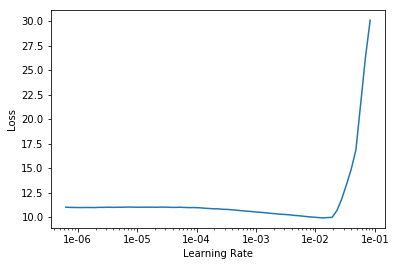

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15,3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.211560,3.973259,0.533767,0.296959,02:46
1,2.288683,4.115649,0.507748,0.372423,02:19
2,2.237403,4.340171,0.480048,0.389193,02:19
3,2.180545,4.544856,0.465811,0.385388,02:14
4,2.061826,3.297514,0.538278,0.356199,02:21
5,1.956458,3.642374,0.505945,0.395031,02:15
6,1.927408,4.178248,0.449730,0.391585,02:14
7,1.889459,3.743475,0.478988,0.407258,02:16
8,1.755543,4.114755,0.433610,0.385047,02:15
9,1.831728,3.985462,0.449586,0.392925,02:12


In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[700], targets[700], outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who has the changes to the regulations and regulations and regulations ?)

In [0]:
inputs[701], targets[701], outputs[701]

(Text xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?,
 Text xxbos what happened to their great xxunk about transparency and accountability ?,
 Text xxbos what are the main reasons for the and and the ?)

In [0]:
inputs[4002], targets[4002], outputs[4002]

(Text xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?,
 Text xxbos what resources exist in your community that would promote recovery ?,
 Text xxbos what resources does your community have to the ?)

The prediction now improved better and better

# Translation with Transformer : without using RNN

[Video 18](https://youtu.be/KzfyftiH7R8)

## Mutlti-head attention : The Beasts with many heads

The paper further refined the self-attention layer by adding a mechanism called “multi-headed” attention. This improves the performance of the attention layer in two ways:

1. It expands the model’s ability to focus on different positions. Yes, in the example above, z1 contains a little bit of every other encoding, but it could be dominated by the the actual word itself. It would be useful if we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, we would want to know which word “it” refers to.

2. It gives the attention layer multiple “representation subspaces”. As we’ll see next, with multi-headed attention we have not only one, but multiple sets of Query/Key/Value weight matrices (the Transformer uses eight attention heads, so we end up with eight sets for each encoder/decoder). Each of these sets is randomly initialized. Then, after training, each set is used to project the input embeddings (or vectors from lower encoders/decoders) into a different representation subspace.

![alt text](http://jalammar.github.io/images/t/transformer_attention_heads_qkv.png)

    With multi-headed attention, we maintain separate Q/K/V weight matrices for each head resulting in different Q/K/V matrices. As we did before, we multiply X by the WQ/WK/WV matrices to produce Q/K/V matrices.

If we do the same self-attention calculation we outlined above, just eight different times with different weight matrices, we end up with eight different Z matrices.

![alt text](http://jalammar.github.io/images/t/transformer_attention_heads_z.png)

This leaves us with a bit of a challenge. The feed-forward layer is not expecting eight matrices – it’s expecting a single matrix (a vector for each word). So we need a way to condense these eight down into a single matrix.

How do we do that? We concat the matrices then multiple them by an additional weights matrix $W^O$.

![alt text](http://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

That’s pretty much all there is to multi-headed self-attention. It’s quite a handful of matrices, I realize. Let me try to put them all in one visual so we can look at them in one place

![alt text](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

Now that we have touched upon attention heads, let’s revisit our example from before to see where the different attention heads are focusing as we encode the word “it” in our example sentence:

![alt text](http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png)

    As we encode the word "it", one attention head is focusing most on "the animal", while another is focusing on "tired" -- in a sense, the model's representation of the word "it" bakes in some of the representation of both "animal" and "tired".
    
If we add all the attention heads to the picture, however, things can be harder to interpret:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization_3.png)

## Representing The Order of The Sequence Using Positional Encoding

One thing that’s missing from the model as we have described it so far is a way to account for the order of the words in the input sequence.

To address this, the transformer adds a vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word, or the distance between different words in the sequence. The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into Q/K/V vectors and during dot-product attention.

![alt text](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)

    To give the model a sense of the order of the words, we add positional encoding vectors -- the values of which follow a specific pattern.
    
If we assumed the embedding has a dimensionality of 4, the actual positional encodings would look like this:

![alt text](http://jalammar.github.io/images/t/transformer_positional_encoding_example.png)

What might this pattern look like?

In the following figure, each row corresponds the a positional encoding of a vector. So the first row would be the vector we’d add to the embedding of the first word in an input sequence. Each row contains 512 values – each with a value between 1 and -1. We’ve color-coded them so the pattern is visible.

![alt text](http://jalammar.github.io/images/t/transformer_positional_encoding_large_example.png)


    A real example of positional encoding for 20 words (rows) with an embedding size of 512 (columns). You can see that it appears split in half down the center. That's because the values of the left half are generated by one function (which uses sine), and the right half is generated by another function (which uses cosine). They're then concatenated to form each of the positional encoding vectors.
    
The formula for positional encoding is described in the paper (section 3.5). You can see the code for generating positional encodings in get_timing_signal_1d(). This is not the only possible method for positional encoding. It, however, gives the advantage of being able to scale to unseen lengths of sequences (e.g. if our trained model is asked to translate a sentence longer than any of those in our training set).

## The Residuals

One detail in the architecture of the encoder that we need to mention before moving on, is that each sub-layer (self-attention, ffnn) in each encoder has a residual connection around it, and is followed by a layer-normalization step.

![alt text](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)

If we’re to visualize the vectors and the layer-norm operation associated with self attention, it would look like this:

![alt text](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)

This goes for the sub-layers of the decoder as well. If we’re to think of a Transformer of 2 stacked encoders and decoders, it would look something like this:

![alt text](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)



## The Decoder Side
Now that we’ve covered most of the concepts on the encoder side, we basically know how the components of decoders work as well. But let’s take a look at how they work together.

The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence:

![alt text](http://jalammar.github.io/images/t/transformer_decoding_1.gif)

    After finishing the encoding phase, we begin the decoding phase. Each step in the decoding phase outputs an element from the output sequence (the English translation sentence in this case).
    

The following steps repeat the process until a special symbol is reached indicating the transformer decoder has completed its output. The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

![alt text](http://jalammar.github.io/images/t/transformer_decoding_2.gif)

**The self attention layers in the decoder operate in a slightly different way than the one in the encoder:**

- In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

##The Final Linear and Softmax Layer

The decoder stack outputs a vector of floats. How do we turn that into a word? That’s the job of the final Linear layer which is followed by a Softmax Layer.

The Linear layer is a simple fully connected neural network that projects the vector produced by the stack of decoders, into a much, much larger vector called a logits vector.

Let’s assume that our model knows 10,000 unique English words (our model’s “output vocabulary”) that it’s learned from its training dataset. This would make the logits vector 10,000 cells wide – each cell corresponding to the score of a unique word. That is how we interpret the output of the model followed by the Linear layer.

The softmax layer then turns those scores into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

![alt text](http://jalammar.github.io/images/t/transformer_decoder_output_softmax.png)

    This figure starts from the bottom with the vector produced as the output of the decoder stack. It is then turned into an output word.

## Recap Of Training
Now that we’ve covered the entire forward-pass process through a trained Transformer, it would be useful to glance at the intuition of training the model.

During training, an untrained model would go through the exact same forward pass. But since we are training it on a labeled training dataset, we can compare its output with the actual correct output.

To visualize this, let’s assume our output vocabulary only contains six words(“a”, “am”, “i”, “thanks”, “student”, and `“<eos>”` (short for ‘end of sentence’)).

![alt text](http://jalammar.github.io/images/t/vocabulary.png)

    The output vocabulary of our model is created in the preprocessing phase before we even begin training.
    
Once we define our output vocabulary, we can use a vector of the same width to indicate each word in our vocabulary. This also known as one-hot encoding. So for example, we can indicate the word “am” using the following vector:

![alt text](http://jalammar.github.io/images/t/one-hot-vocabulary-example.png)

Following this recap, let’s discuss the model’s loss function – the metric we are optimizing during the training phase to lead up to a trained and hopefully amazingly accurate model.


## The Loss Function

Say we are training our model. Say it’s our first step in the training phase, and we’re training it on a simple example – translating “merci” into “thanks”.

What this means, is that we want the output to be a probability distribution indicating the word “thanks”. But since this model is not yet trained, that’s unlikely to happen just yet.

![alt text](http://jalammar.github.io/images/t/transformer_logits_output_and_label.png)

    Since the model's parameters (weights) are all initialized randomly, the (untrained) model produces a probability distribution with arbitrary values for each cell/word. We can compare it with the actual output, then tweak all the model's weights using backpropagation to make the output closer to the desired output.
    
How do you compare two probability distributions? We simply subtract one from the other. For more details, look at [cross-entropy](https://colah.github.io/posts/2015-09-Visual-Information/) and [Kullback–Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained).

But note that this is an oversimplified example. More realistically, we’ll use a sentence longer than one word. For example – input: “je suis étudiant” and expected output: “i am a student”. What this really means, is that we want our model to successively output probability distributions where:

- Each probability distribution is represented by a vector of width vocab_size (6 in our toy example, but more realistically a number like 3,000 or 10,000)
- The first probability distribution has the highest probability at the cell associated with the word “i”
- The second probability distribution has the highest probability at the cell associated with the word “am”
- And so on, until the fifth output distribution indicates `‘<end of sentence>’` symbol, which also has a cell associated with it from the 10,000 element vocabulary.

![alt text](http://jalammar.github.io/images/t/output_target_probability_distributions.png)

    The targeted probability distributions we'll train our model against in the training example for one sample sentence.

After training the model for enough time on a large enough dataset, we would hope the produced probability distributions would look like this:


![alt text](http://jalammar.github.io/images/t/output_trained_model_probability_distributions.png)

    Hopefully upon training, the model would output the right translation we expect. Of course it's no real indication if this phrase was part of the training dataset (see: cross validation). Notice that every position gets a little bit of probability even if it's unlikely to be the output of that time step -- that's a very useful property of softmax which helps the training process.

Now, because the model produces the outputs one at a time, we can assume that the model is selecting the word with the highest probability from that probability distribution and throwing away the rest. That’s one way to do it (called greedy decoding). Another way to do it would be to hold on to, say, the top two words (say, ‘I’ and ‘a’ for example), then in the next step, run the model twice: once assuming the first output position was the word ‘I’, and another time assuming the first output position was the word ‘me’, and whichever version produced less error considering both positions #1 and #2 is kept. We repeat this for positions #2 and #3…etc. This method is called “beam search”, where in our example, beam_size was two (because we compared the results after calculating the beams for positions #1 and #2), and top_beams is also two (since we kept two words). These are both hyperparameters that you can experiment with.

# Attention and the Transformer (implemented code) [Video 18](https://youtu.be/KzfyftiH7R8?t=1284)

See also The [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) from Harvard NLP.

Nvidia AI researcher Chip Huyen wrote a [great post Top 8 trends from ICLR 2019](https://huyenchip.com/2019/05/12/top-8-trends-from-iclr-2019.html) in which one of the trends is that RNN is losing its luster with researchers.

There's good reason for this, RNNs can be a pain: parallelization can be tricky and they can be difficult to debug. Since language is recursive, it seemed like RNNs were a good conceptual fit with NLP, but recently methods using attention have been achieving state of the art results on NLP.

This is still an area of very active research, for instance, a recent paper [Pay Less Attention with Lightweight and Dynamic Convolutions](https://arxiv.org/abs/1901.10430) showed that convolutions can beat attention on some tasks, including English to German translation. More research is needed on the various strenghts of RNNs, CNNs, and transformers/attention, and perhaps on approaches to combine the best of each.

In [0]:
data = load_data(path)

In [0]:
data.show_batch()

text,target
"xxbos que faut - il prévoir pour établir des règles , des critères et des processus xxunk et uniformes aux fins des décisions sur l’accès et sur la répartition ?","xxbos what is needed to establish clear and consistently applied rules , criteria and processes for access and allocation decision making ?"
xxbos quelle proportion de la population doit être exposée à un risque grave potentiel pour que l’on xxunk à la présence d’un risque grave pour l’ensemble de la population ?,xxbos what portion of the population must be exposed to potential serious risk for it to be a serious risk to the population as a whole ?
xxbos quelles sont les dispositions applicables dans le cas où les renseignements fournis dans la demande de brevet déposée dans votre pays sont faux ou susceptibles xxunk en erreur ?,xxbos what provisions apply in the event that information provided in a patent application in your country is false or misleading ?
xxbos en quoi la collecte de données de qualité est - elle importante pour la lutte contre le racisme et la protection des droits humains fondamentaux des minorités vulnérables ?,xxbos why is good data collection important to combat racism and for the protection of vulnerable minorities ’ fundamental human rights ?
xxbos quels sont les indications et les critères appropriés à prendre en compte pour un essai clinique visant à xxunk la pose d'un xxunk dans l'artère xxunk gauche principale ?,xxbos what are appropriate indications and endpoints for a clinical trial to investigate stenting of the left main coronary artery ?


## Transformer model

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/Transformer.png)

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [0]:
v = data.vocab

In [0]:
v.stoi['xxpad']

1

we have to shift the target over one since we are predicting the next step

In [0]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y,(1,0),value=1)
    return [x,y[:,:-1]],y[:,1:]

In [0]:
data.add_tfm(shift_tfm)

### Embeddings

RNN has a concept of time since you're passing things in sequencially at each time step, you get the next word in the sentence. And that's not the case with attention because you give it everything at once and there's no notion of order so positional encoding is a way of address this. Actually, the picture below is a great picture to describe this.

![alt text](http://jalammar.github.io/images/t/transformer_positional_encoding_large_example.png)

Basically, we can use sin and cosin to come up with this matrix that capture the position. Because there's like a different value at each position and you will get these patterns across your two directions and so this is added to the input to encode the position. This is what look like to add sin and cosin. That is both varying across the x and the y. This would be like a batch of sentences.

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:



In [0]:
d = 30
torch.arange(0.,d,2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [0]:
class PositionalEncoding(nn.Module):
    "Encode the position with sinusoid"
    def __init__(self,d):
        super().__init__()
        self.register_buffer('freq',1/(10000**(torch.arange(0.,d,2.)/d)))
        
    def forward(self,pos):
        inp = torch.ger(pos,self.freq)
        enc = torch.cat([inp.sin(),inp.cos()],dim=-1)
        return enc
       

**`self.register_buffer('freq',1/(10000**(torch.arrange(0.,d,2.)/d)))`**: 
- torch.arrange(0.,d,2.) is the linspace : get the evenly spaced steps. Here we take steps of size. d is the dimension



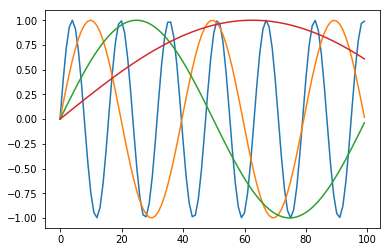

In [0]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_,ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [0]:
res[:6,:6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

We have zeros on the first row and then it's kind of varying on both horizontal side or vertical side of dimension 

Create a transformer embedding which is basically taking a normal embedding (`self.embed = embedding(vocab_sz,emb_sz`). Then put into positional encoder (`PositionalEncoding(emb_sz)`). Finall using dropout

Then we apply normalization by mutilpying `math.sqrt(self.emb_sz)`. This give embedding kind of more proportional weight compared to the positional encoding 

In [0]:
class TransformerEmbedding(nn.Module):
    #Embedding + positional encoding + dropout
    def __init__(self,vocab_sz,emb_sz,inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz,emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
        
    def forward(self,inp):
        pos = torch.arange(0,inp.size(1),device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz)+self.pos_enc(pos))

### Feed forward

The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm. 

It is traditional fully connected neural networks including a linear layer and ReLU(), then we append some dropout.

SequentialEx() is Fastai way of doing sequential, lets you include concatenating with the identity. 

(identity and skip connection)????

In [0]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model,d_ff),nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers,nn.Linear(d_ff,d_model),nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/attention.png)

The left is single-head attention called **Scaled Dot-product Attention** (explained above). Basically, you can think of Q is representing the words from sequence 1. K and V are representing the words from sequence 2. You are using Q and K together to come up with the weight of how much weight to give to each word in sequence 2 when you're taking this weighted average 

**`self.n_heads,self.d_head,n.scale = n_heads,d_head,scale`**

- n_heads = the number of heads
- d__head = the dimension of each head

**`self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(d_model,n_heads*d_head,bias=bias) for o in range(3)]`**
- self.q_wgt,sel.k_wgt,self.v_wgt = Q, K, V
- put those all together . It's linear layer, you're learning these weights

**`self.drop_att, self.drop_res = nn.Dropout(p),nn.Dropout(p)`**
- we have dropout for our attention(drop_att) and the result (drop_res)

**`return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))`**

- going to apply attention so we'll look at that it's taking q+kv is input. The reason we have kv is because K and V are the same thing. So the weight matrices WK + WV are different but K and V are the same, that's because it's talking about same word and sequence. That's figuring out how much weight to give to

`bs, seq_len = q.size(0), q.size(1)`:

- bs : batchsize and seq_len : sequence length

`wq, wk, wv = map(lambda o: self.create_attn_mat(*o,bs),
                        zip((q,kv,kv),(self.q_wqt,self.v_wgt)))`
                        
- call `self.create_attn_mat(*o,bs)` method to create a tensor matrix on q and kv, kv. The reason we're feeding kv and kv is when it'll be used as K and the other time is V with the weights for Q, K

- `self.create_attn_mat()` : creating a layer want to view this as batch size * the first dimension from x which is the length of sequence * the number of heads * the dimension of head. There's some permuting that has to happen just for these to kind of line up correctly when you do the multiplication

`attn_score = wq @ wk.transpose(2,3)`: the attention score here is just wq* wk . So that give us weights for V then we can take this weighted average for V

`attn_prob = self.drop_att(F.softmax(attn_score,dim=-1))`: the attention probability: we apply our dropout softmax of the attention score 

`attn_vec = attn_prob @ wv` : apply those probabilities to wv so here is attention vector that is the true weighted average




In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)


**The Transformer uses Multi-Head Attention in three different ways:**

1. The encoder internally contains self-attention layers. In a self-attention layer, all of the keys, values and the queries come from the same place, in this case — the output of the previous layer of the encoder. The input to the multi-head self-attention Is the input sequence itself (the keys, values and also the queries in various linear transformed heads)
2. In the encoder-decoder attention layers, the queries come from the previous decoder layer, and the keys and values come from the output of the encoder. This allows every position in the decoder to attend over all the positions in the input sequence (similar to the typical encoder-decoder architecture)
3. Similarly, self-attention layers in the decoder will allow each position in the decoder to attend to all positions in the decoder up to and including that position.
4. To prevent the leftward information flow in the decoder, masking support is implemented inside of the scaled dot-product attention by masking out all values in the input of the softmax of the multi-head attention which corresponds to illegal connections (masking of future/subsequent words).

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [0]:
def get_output_mask(inp,pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

Example of mask for the future tokens: 

You just use this upper triangle matrix of ones to cover up everything in the future. 

- In the first timestep `[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]`, you can't see anything that coming ahead. 

- In the second timestep `[0, 0, 1, 1, 1, 1, 1, 1, 1, 1]`, you know the first two things

- ...

In [0]:
torch.triu(torch.ones(10,10),diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Encoder and decoder blocks [45:56](https://youtu.be/KzfyftiH7R8?t=2756)
We are now ready to regroup these layers in the blocks we add in the model picture:

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/Transformer.png)



In [0]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))


in the EncoderBlock, it takes in the number of heads, the dimension of the model and the dimension of each head. Then the feed_forward comes after.

In the forward step, it call multi-attention(self.mha) and it's passing x,x.
- the first x corresponds to the query
- the second x will be used for both the key and the value because you need to calculate the score using the key in query. Then that gives you a scaled version of the value 

In [0]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

The DecoderBlock has two multi-head attention classes. In the forward step, the first self.mha1(x,x,maskout) will the x twice and then call self.mha2 of the first one and encoder (enc)

### The whole model

In [0]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

In [0]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


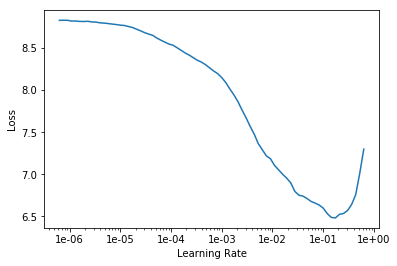

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8,5e-4,div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.522872,2.681311,0.591845,0.438670,01:14
1,2.073438,2.147375,0.665009,0.481491,01:16
2,1.652717,1.795897,0.703587,0.516762,01:15
3,1.360806,1.586568,0.730306,0.545852,01:15
4,1.209838,1.450785,0.748134,0.567464,01:16
5,1.054355,1.396276,0.757876,0.579720,01:14
6,0.860845,1.385509,0.762807,0.586177,01:15
7,0.833035,1.388019,0.763609,0.588009,01:15


In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
inputs[10],targets[10],outputs[10]

(Text xxbos quelles méthodes a - t - on trouvées particulièrement efficaces pour consulter le public et les parties intéressées sur la protection des renseignements personnels reliés à la santé ?,
 Text xxbos what approaches have been found particularly effective in consulting with the public and stakeholders on the protection of personal health information ?,
 Text xxbos what methods have been useful particularly effective in the the the public and stakeholders in personal personal of personal health information ?)

In [0]:
inputs[700],targets[700],outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who has the authority to change the xxunk and what measures measures and the label of regulations that ?)

In [0]:
inputs[701],targets[701],outputs[701]

(Text xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?,
 Text xxbos what happened to their great xxunk about transparency and accountability ?,
 Text xxbos what were to their main beliefs or transparency and transparency ?)

In [0]:
inputs[2500],targets[2500],outputs[2500]

(Text xxbos de quoi l’afrique a - t - elle vraiment besoin pour se sortir de la pauvreté ?,
 Text xxbos what does africa really need to pull itself out of poverty ?,
 Text xxbos what does africa really need to achieve out out of poverty ?)

In [0]:
inputs[4002],targets[4002],outputs[4002]

(Text xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?,
 Text xxbos what resources exist in your community that would promote recovery ?,
 Text xxbos what resources does that your community that has facilitate the ?)

#### Label smoothing

The other thing that transformer uses is label smoothing. This is jus basically idea of since we're predicting predictions , often use softmax with 100% on correct answer and 0% on everything else. The idea of label smoothing is to put 90% on correct answer and evenly divide other 10% among all other words. That would improve the accuracy of model because it really kind of getting a prediction of everything in 90% is better than overconfident get a 100% on everything

They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [0]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [0]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [0]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

In [0]:
print("Quels sont les atouts particuliers du Canada en recherche sur l'obésité sur la scène internationale ?")
print("What are Specific strengths canada strengths in obesity - ? are up canada ? from international international stage ?")
print("Quelles sont les répercussions politiques à long terme de cette révolution scientifique mondiale ?")
print("What are the long the long - term policies implications of this global scientific ? ?")

In [0]:
inputs[10],targets[10],outputs[10]

In [0]:
inputs[700],targets[700],outputs[700]

In [0]:
inputs[701],targets[701],outputs[701]

In [0]:
inputs[4001],targets[4001],outputs[4001]

## Understand Positional Encoding